In [19]:
import math
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
sys.path.append("/home/irene/Documents/audio-diffusion-pytorch-trainer")

from main.separation import ContextualSeparator, differential_with_gaussian, differential_with_dirac
from pathlib import Path
from audio_diffusion_pytorch import KarrasSchedule
import torch
from script.misc import hparams
import main.module_base
from IPython.display import Audio
device = torch.device("cuda")
ROOT_PATH = Path(".")
%load_ext autoreload
%autoreload 2

sampling_rate = 22050

# @markdown Generation length in seconds (will be rounded to be a power of 2 of sample_rate*length)
length = 10
length_samples = 2**math.ceil(math.log2(length * sampling_rate))

# @markdown Number of samples to generate
num_samples = 10

# @markdown Number of diffusion steps (higher tends to be better but takes longer to generate)
num_stems = 4

smin = 1e-4
smax = 1.0
rho = 7.0
sigma_schedule=KarrasSchedule(sigma_min=smin, sigma_max=smax, rho=rho)

def load_model(path):
  model = main.module_base.Model(**{**hparams, "in_channels": 4})
  model.load_state_dict(torch.load(path)["state_dict"])
  model.to(device);
  return model

def gamma_fn(x):
    return x / 0.5


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = load_model("/home/irene/Documents/audio-diffusion-pytorch-trainer/logs/ckpts/avid-darkness-164_epoch=419-valid_loss=0.015.ckpt")

In [3]:
def sisnr(preds: torch.Tensor, target: torch.Tensor, eps: float = 1e-5) -> torch.Tensor:
    alpha = (torch.sum(preds * target, dim=-1, keepdim=True) + eps) / (torch.sum(target**2, dim=-1, keepdim=True) + eps)
    target_scaled = alpha * target
    noise = target_scaled - preds
    s_target = torch.sum(target_scaled**2, dim=-1) + eps
    s_error = torch.sum(noise**2, dim=-1) + eps
    return 10 * torch.log10(s_target / s_error)

def sisnr_i(sep, ori, m):
    return sisnr(sep, ori) - sisnr(m, ori)

sources_names = ["bass", "drums", "guitar", "piano"]
generator1 = torch.Generator().manual_seed(1)
generator2 = torch.Generator().manual_seed(42)

In [4]:
# Tracks loading
track_list = []
srs = []
while len(track_list) < num_samples:
    track_n = torch.randint(low=1876, high=2098, size=(1,), dtype=torch.int, generator=generator2)[0]
    start_sample_n = torch.randint(high=120, size=(num_samples,), dtype=torch.int, generator=generator1)[0]
    start_sample = start_sample_n * sampling_rate
    stem_list = []
    is_silence_list = []
    mix = torch.zeros((1, 1, length_samples))
    flag = False
    for name in sources_names:
        try:
            s, sr = torchaudio.load(f'/home/irene/Documents/audio-diffusion-pytorch-trainer/data/Slack/test/{name}/Track0{track_n}.wav')
        except:
            flag = True
            break
        s = torchaudio.functional.resample(s, orig_freq=sr, new_freq=sampling_rate)
        s = s.reshape(1, 1, -1)[:, :, start_sample:start_sample + length_samples]
        stem_list.append(s)
        is_silence_list.append((s == 0.).all()) # 1 means that is silence
        mix += s
    if flag or sum(is_silence_list) > 0 or mix.norm() < 10e-5:
        continue
    stems = torch.concat(stem_list, axis=1)
    track_list.append(stems)

tracks_gt = torch.concat(track_list, axis=0).to(device)
display(f"{tracks_gt.shape=}")

m = tracks_gt.sum(axis=1, keepdim=True)
display(m.shape)

'tracks_gt.shape=torch.Size([10, 4, 262144])'

torch.Size([10, 1, 262144])

In [15]:
#display(Audio(tracks[0,0], rate = sampling_rate))
display(Audio(m[8].cpu().detach(), rate = sampling_rate))

In [10]:
#differential_fn = partial(differential_with_gaussian, gamma_fn=gamma_fn)
differential_fn = differential_with_dirac
separator = ContextualSeparator(model=model, 
                                stems=["bass", "drums", "guitar", "piano"], 
                                sigma_schedule=sigma_schedule,
                                num_resamples=3,
                                differential_fn=differential_fn,
                                s_churn=20.)
num_steps = 150

In [ ]:
# GROUND TRUTH HINT (if fixed_sources_idx = [] is standard separation)

from main.separation import differential_with_gaussian
def generate_mask_and_sources(sources, fixed_sources_idx=[]):
    mobile_sources_idx = list(set([0,1,2,3]) - set(fixed_sources_idx))
    mobile_sources_idx.sort()
    inpaint                = torch.randn(num_samples, num_stems, length_samples).to(device)
    if len(fixed_sources_idx) > 0:
        inpaint[:, fixed_sources_idx, :]       = sources[:, fixed_sources_idx, :]
    inpaint_mask           = torch.ones_like(inpaint)
    inpaint_mask[:, mobile_sources_idx, :] = 0.
    return inpaint, inpaint_mask

sources_idx=torch.arange(4, device=device)

fixed_sources_idx = []
inpaint, inpaint_mask = generate_mask_and_sources(sources=tracks_gt, fixed_sources_idx=fixed_sources_idx)
separations_hint = separator.separate_with_hint(
    mixture=m,
    source_with_hint=inpaint,
    mask=inpaint_mask,
    num_steps=num_steps,
)
sources = torch.cat([separations_hint["bass"], separations_hint["drums"],
                     separations_hint["guitar"], separations_hint["piano"]], axis=1).to(device)

In [ ]:
# Plot results
sources_names = ["bass", "drums", "guitar", "piano"]
ss = []
for i in range(4):
    s = sisnr_i(separations_hint[sources_names[i]], tracks_gt[:,[i],:], m.to(device))
    print(f"{sources_names[i]}: mean = {s.mean().tolist()}, std = {s.std().tolist()}\n")
    ss.append(s)
ss = torch.stack(ss)
mobile_sources_idx = list(set([0, 1, 2, 3]) - set(fixed_sources_idx))
mean = sum(ss[mobile_sources_idx]) / len(mobile_sources_idx)
print(f"overall (exclude fix sources) mean = {mean.mean().tolist()}, std = {mean.std().tolist()}")

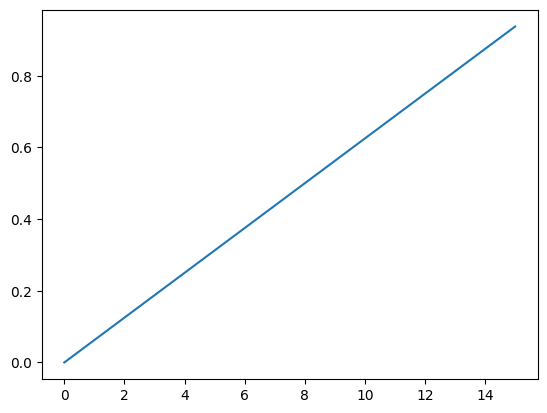

In [33]:
T = 16
p_max = (T - 1) / T
p_min = p_max * (1 - 0.95)
def schedule_prob(t, T, alpha=0.95, p_min=p_min, p_max=p_max):
    p_t = 1 - max(0, p_max - (t - 1) * (p_max - p_min) / (alpha * (T - 1)))
    return p_t

plt.plot([schedule_prob(i, T) for i in range(T)])

In [ ]:
# GIBSS
def generate_mask_and_sources(sources, fixed_sources_idx=[]):
    mobile_sources_idx = list(set([0, 1, 2, 3]) - set(fixed_sources_idx))
    mobile_sources_idx.sort()
    inpaint                = torch.randn(num_samples, num_stems, length_samples).to(device)
    inpaint[:, fixed_sources_idx, :]       = sources[:, fixed_sources_idx, :]
    inpaint_mask           = torch.ones_like(inpaint)
    inpaint_mask[:, mobile_sources_idx, :] = 0.
    return inpaint, inpaint_mask

sources_idx=torch.arange(4, device=device)

for i in tqdm(range(T)):
    p = schedule_prob(i, T)
    mask = torch.bernoulli(torch.ones(4, device=device) * p).bool()
    fixed_sources_idx = sources_idx[mask]
    inpaint, inpaint_mask = generate_mask_and_sources(sources=tracks_gt, fixed_sources_idx=fixed_sources_idx)
    separations_hint = separator.separate_with_hint(
        mixture=m,
        num_steps=num_steps,
        mask=inpaint_mask,
        source_with_hint=inpaint,
    )
    sources = torch.cat([separations_hint["bass"], separations_hint["drums"],
                     separations_hint["guitar"], separations_hint["piano"]], axis=1).to(device)
fixed_sources_idx = [] # For computing metrics
# separations_hint_list.append(separations_hint)

In [73]:
ss

tensor([[[ 24.0479],
         [  3.8292],
         [ 16.0107],
         [ 19.0097],
         [ 21.3058],
         [ 25.5457],
         [ 13.2241],
         [  3.4357],
         [ 16.3915],
         [ 17.6461]],

        [[ 19.8129],
         [ 37.2957],
         [ 14.4803],
         [ 21.3391],
         [ 20.0190],
         [ 19.3052],
         [ 17.7871],
         [  4.9803],
         [ 20.7696],
         [ 24.9352]],

        [[ 17.0847],
         [  9.3247],
         [ 16.4899],
         [  3.0584],
         [  9.3435],
         [  9.5033],
         [  6.4340],
         [-11.2764],
         [  9.8151],
         [ 15.1242]],

        [[ 18.6868],
         [ -3.0239],
         [ 17.3083],
         [  2.4523],
         [  8.5873],
         [ 10.9763],
         [  6.4288],
         [ 26.3056],
         [  9.0320],
         [ 15.5491]]], device='cuda:0')

In [74]:
display(Audio(separations_hint["drums"][1].squeeze().squeeze().cpu().detach(), rate = sampling_rate))
display(Audio(tracks_gt[1][1].squeeze().squeeze().cpu().detach(), rate = sampling_rate))

Resample
1) 1, (3, 10) resample I ordine 100, (300, 1000) step
2) a) 1 resample II ordine 10, 100 step b) provare nuovi sampler shneider
3) dirac con variazioni sorgente
4) dirac 4 sep con ogni volta una sorgente diversa fissata
5) calcolare la media dei gradienti
6) likelihood

# Likelihood test

In [20]:
from main.separation import log_likelihood

In [21]:
f = model.model.diffusion.denoise_fn
log_likelihood(f, tracks_gt[0], 0.002, 1)

RuntimeError: The size of tensor a (4194308) must match the size of tensor b (1048580) at non-singleton dimension 0

In [11]:
model.forward

<bound method LightningModule.forward of Model(
  (model): AudioDiffusionModel(
    (unet): UNet1d(
      (to_mapping): Sequential(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): GELU(approximate=none)
        (2): Linear(in_features=1024, out_features=1024, bias=True)
        (3): GELU(approximate=none)
      )
      (to_time): Sequential(
        (0): Sequential(
          (0): LearnedPositionalEmbedding()
          (1): Linear(in_features=257, out_features=1024, bias=True)
        )
        (1): GELU(approximate=none)
      )
      (to_in): Patcher(
        (module_list): ModuleList(
          (0): PatchBlock(
            (block): ResnetBlock1d(
              (block1): ConvBlock1d(
                (groupnorm): GroupNorm(4, 4, eps=1e-05, affine=True)
                (activation): SiLU()
                (project): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
              )
              (to_scale_shift): MappingToScaleShift(
           